In [2]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score, train_test_split

import xgboost as xgb

from skopt import gp_minimize
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

In [3]:
df_option = pd.read_pickle("dev_df_final_jointed_all_train_beta.pkl")
df_option.reset_index(inplace=True)

X = df_option.drop(['Date_Only','Target_spread', 'Target_std'], axis=1)  
y = df_option['Target_spread']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

## Define the Hyperparameter Space

Scikit-optimize provides an utility function to create the range of values to examine for each hyperparameters. More details in [skopt.Space](https://scikit-optimize.github.io/stable/modules/generated/skopt.Space.html)

In [58]:
# # determine the hyperparameter space

# param_grid = [
#     Integer(10, 2500, name='n_estimators'),
#     Integer(1, 10, name='max_depth'),
#     Real(0.01, 0.99, name='learning_rate'),
#     Categorical(['gbtree', 'dart'], name='booster'),
#     Real(0.01, 10, name='gamma'),
#     Real(0.50, 0.90, name='subsample'),
#     Real(0.50, 0.90, name='colsample_bytree'),
#     Real(0.50, 0.90, name='colsample_bylevel'),
#     Real(0.50, 0.90, name='colsample_bynode'),
#     Integer(1, 50, name='reg_lambda'),
# ]

# # Scikit-optimize parameter grid is a list
# type(param_grid)

In [59]:
param_grid = [
    Integer(10, 1000, name='n_estimators'),
    Integer(1, 10, name='max_depth'),
    Real(0.01, 0.99, name='learning_rate'),
    Real(0.50, 0.90, name='subsample'),
    Real(0.50, 0.90, name='colsample_bytree'),

]

In [ ]:
    # 'n_estimators': [100, 200, 300],
    # 'max_depth': [3, 4, 5],
    # 'learning_rate': [0.01, 0.1, 0.2],
    # 'subsample': [0.7, 0.8, 0.9],
    # 'colsample_bytree': [0.6, 0.7, 0.8]

## Define the model

In [60]:
# set up the gradient boosting classifier

gbm = xgb.XGBRegressor(random_state=1000)

## Define the objective function

This is the hyperparameter response space, the function we want to minimize.

In [61]:
# We design a function to maximize the accuracy, of a GBM,
# with cross-validation

# the decorator allows our objective function to receive the parameters as
# keyword arguments. This is a requirement of Scikit-Optimize.
@use_named_args(param_grid)
def objective(**params):
    
    # model with new parameters
    gbm.set_params(**params)

    # optimization function (hyperparam response function)
    value = np.mean(
        cross_val_score(
            gbm, 
            X_train,
            y_train,
            cv=3,
            n_jobs=-4,
            scoring='neg_root_mean_squared_error')
    )

    # negate because we need to minimize
    return -value

## Bayesian Optimization

We are now ready for sequential model-based optimization. Here we use Gaussian process-based Optimization.

In [62]:
# gp_minimize performs by default GP Optimization 
# using a Marten Kernel

gp_ = gp_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    n_initial_points=10, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    n_calls=50, # the number of subsequent evaluations of f(x)
    random_state=0, 
)

C:\Users\jepar\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [906, 1, 0.01, 0.5, 0.5] before, using random point [971, 9, 0.6504805412871513, 0.8505841218359214, 0.5812146622085543]
  warnings.warn(


In [63]:
# function value at the minimum.
# note that it is the negative of the accuracy

"Best score=%.4f" % gp_.fun

'Best score=2.2672'

In [64]:
gp_.x

[1000, 1, 0.01, 0.5, 0.5]

In [65]:
print("""Best parameters:
=========================
- n_estimators = %d
- max_depth = %d
- learning_rate = %.6f
- booster = %s
- gamma = %.6f
= subsample = %.6f
- colsample_bytree = %.6f
- colsample_bylevel = %.6f
- colsample_bynode' = %.6f
""" % (gp_.x[0],
       gp_.x[1],
       gp_.x[2],
       gp_.x[3],
       gp_.x[4],
       gp_.x[5],
       gp_.x[6],
       gp_.x[7],
       gp_.x[8],
      ))

IndexError: list index out of range

In [66]:
gp_.x[0]

1000

In [67]:
xgbr = xgb.XGBRegressor(n_estimators = gp_.x[0], max_depth = gp_.x[1],
                        learning_rate = gp_.x[2], booster = gp_.x[3], 
                        gamma = gp_.x[4], subsample = gp_.x[5],
                        colsample_bytree =  gp_.x[6],colsample_bylevel =  gp_.x[7],
                        colsample_bynode =  gp_.x[8])

IndexError: list index out of range

In [55]:
def run_model(model,X_train,y_train,X_test,y_test):
    
    # Fit Model
    model.fit(X_train,y_train)
    
    # Get Metrics
    
    preds = model.predict(X_test)
    
    mae = mean_absolute_error(y_test,preds)
    print(f'mae : {mae}')
   
    
    plt.figure(figsize=(12,8),dpi=200)
    plt.scatter(y_test, preds)
    plt.xlabel('real_std')

    return model

mae : 1.344673524725025


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=0.5, colsample_bynode=0.9, colsample_bytree=0.5,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=10.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2500, n_jobs=None,
             num_parallel_tree=None, ...)

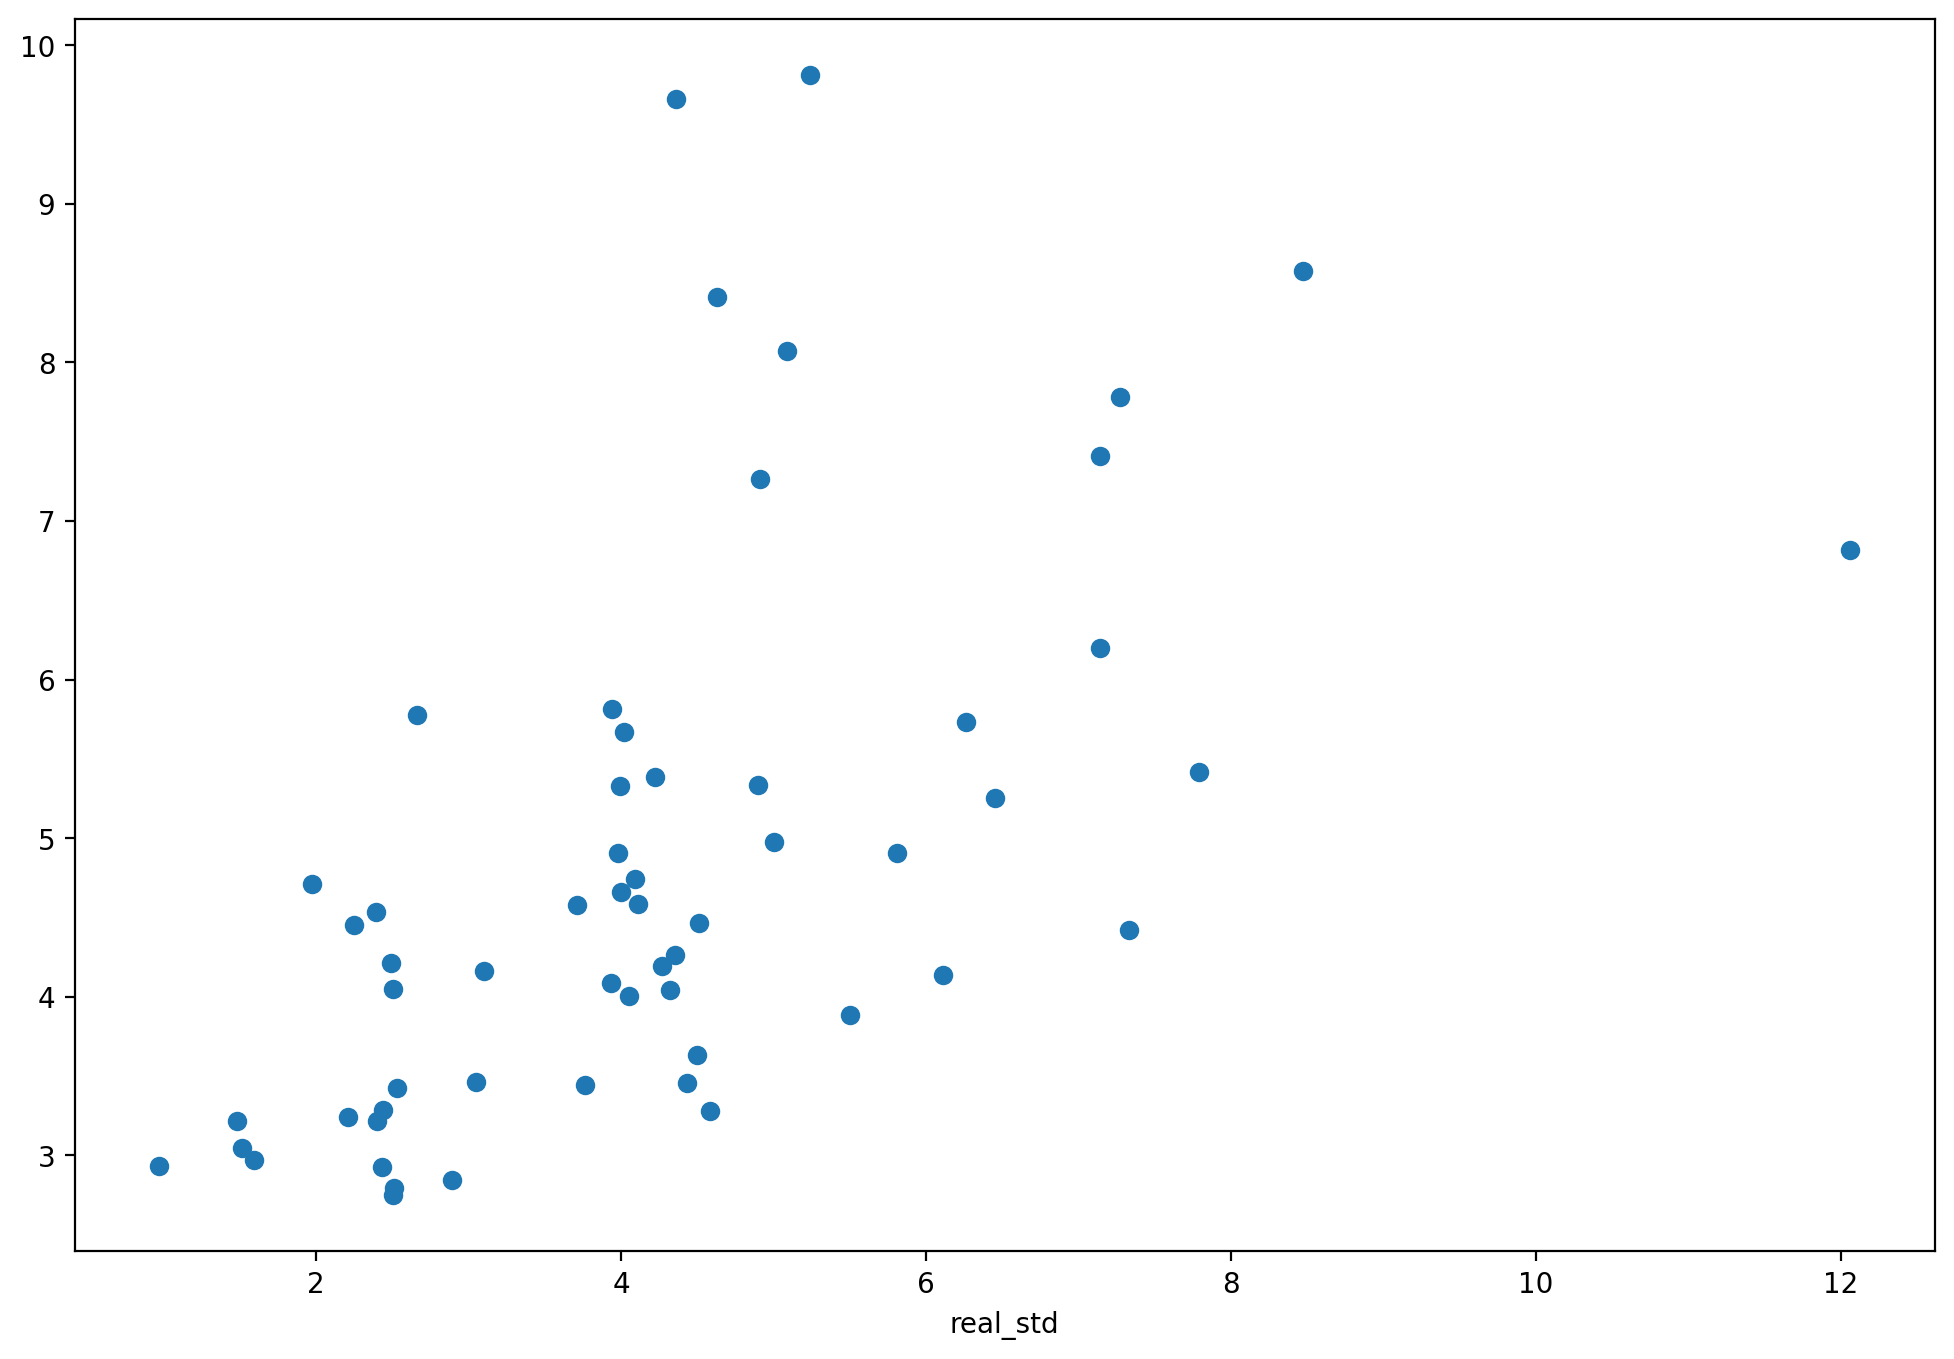

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
run_model(xgbr,X_train,y_train,X_test,y_test)

## Evaluate convergence of the search

[plot_convergence](https://scikit-optimize.readthedocs.io/en/latest/modules/generated/skopt.plots.plot_convergence.html#skopt.plots.plot_convergence)

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

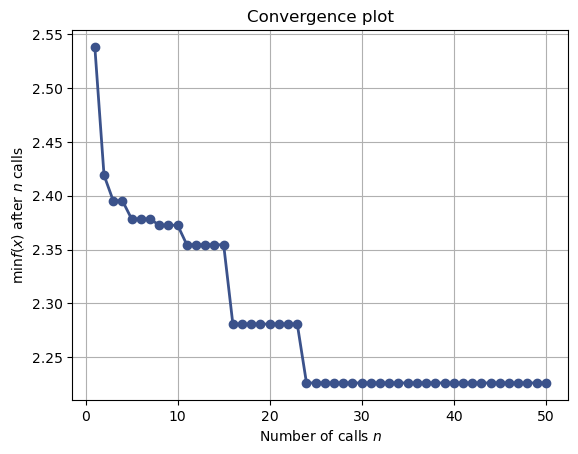

In [57]:
plot_convergence(gp_)